In [11]:
#0: imports

import uproot 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from imports.data_resp import CCV3
from torch_geometric.data import DataLoader 
from imports.models import Net_DE, Net_GAT, Net_Trans
from torch_geometric.nn import knn_graph

import numpy as np
import awkward as ak
import time
from imports.Agglomerative import Aggloremative

import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [12]:
df_GAT = pd.read_csv("csvRes/df_GAT_pi_res.csv")
df_DE = pd.read_csv("csvRes/df_DEC_pi_res.csv")
df_Trans = pd.read_csv("csvRes/df_Trans_pi_res.csv")
df_Track = pd.read_csv("csvRes/df_Track_pi_res.csv")
df_MT = pd.read_csv("csvRes/df_MT_pi_res.csv")


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define allowed energies for CaloParticles
allowed_energies = np.array([25, 50, 75, 100, 150, 200])

def process_cp_dataframe(df):
    """Convert columns to numeric and keep only events with exactly one calo particle id (selecting the row with highest shared_energy if needed)."""
    df = df.copy()
    for col in ['cp_id', 'cp_energy', 'energy_ratio', 'shared_energy']:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # For each (event_index, cp_id), keep the row with the highest shared_energy.
    df_cp = df.loc[df.groupby(['event_index', 'cp_id'])['shared_energy'].idxmax()].reset_index(drop=True)
    
    # Only keep events that have exactly one unique cp_id.
    valid_events = df_cp.groupby('event_index')['cp_id'].nunique()
    valid_events = valid_events[valid_events == 1].index
    df_cp = df_cp[df_cp['event_index'].isin(valid_events)]
    
    return df_cp

# Process each DataFrame
df_CL_cp = process_cp_dataframe(df_CL)
df_TICL_cp = process_cp_dataframe(df_TICL)
# Removed processing for df_CL_pi

# Map each cp_energy to a bin based on allowed energies
energy_to_bin = {energy: idx for idx, energy in enumerate(allowed_energies)}
df_CL_cp['energy_bin'] = df_CL_cp['cp_energy'].map(energy_to_bin)
df_TICL_cp['energy_bin'] = df_TICL_cp['cp_energy'].map(energy_to_bin)
# Removed mapping for df_CL_pi

def compute_scaled_sigma_effective(df, num_bins):
    """
    For each energy bin, scale the energy_ratio data so the mean is 1, then compute the sigma effective
    as the width of the narrowest window covering 68.3% of the data.
    """
    effective_mean_scaled, sigma_eff_scaled, counts = [], [], []
    for b in range(num_bins):
        bin_data = df.loc[df['energy_bin'] == b, 'energy_ratio'].dropna()
        counts.append(len(bin_data))
        if len(bin_data) > 0:
            mean_arith = np.mean(bin_data)
            scaled_data = bin_data / mean_arith
            sorted_data = np.sort(scaled_data)
            n_points = len(sorted_data)
            window_size = max(1, int(0.683 * n_points))
            min_width = np.inf
            best_range = (None, None)
            for i in range(n_points - window_size):
                width = sorted_data[i + window_size] - sorted_data[i]
                if width < min_width:
                    min_width = width
                    best_range = (sorted_data[i], sorted_data[i + window_size])
            mu_eff = (best_range[0] + best_range[1]) / 2 
            sigma_eff_val = (best_range[1] - best_range[0]) / np.sqrt(2)
            effective_mean_scaled.append(mu_eff)
            sigma_eff_scaled.append(sigma_eff_val)
        else:
            effective_mean_scaled.append(np.nan)
            sigma_eff_scaled.append(np.nan)
    return np.array(effective_mean_scaled), np.array(sigma_eff_scaled), np.array(counts)

n_bins = len(allowed_energies)
scaled_fitted_mean_CL, scaled_sigma_eff_CL, counts_CL = compute_scaled_sigma_effective(df_CL_cp, n_bins)
scaled_fitted_mean_TICL, scaled_sigma_eff_TICL, counts_TICL = compute_scaled_sigma_effective(df_TICL_cp, n_bins)
# Removed calculation for df_CL_pi

# Plot scaled histograms for selected bins
selected_bins = [0, n_bins // 2, n_bins - 1]
fig_hist, axs = plt.subplots(len(selected_bins), 2, figsize=(12, 4 * len(selected_bins)), constrained_layout=True)

for i, b in enumerate(selected_bins):
    for df, mean_scaled, sigma_scaled, label, color, ax in zip(
            [df_CL_cp, df_TICL_cp],
            [scaled_fitted_mean_CL, scaled_fitted_mean_TICL],
            [scaled_sigma_eff_CL, scaled_sigma_eff_TICL],
            ['Our Model', 'TICL'],
            ['lightblue', 'lightgreen'],
            axs[i] if len(selected_bins) > 1 else [axs]):
        
        bin_data = df.loc[df['energy_bin'] == b, 'energy_ratio'].dropna()
        if len(bin_data) > 0:
            mean_arith = np.mean(bin_data)
            scaled_data = bin_data / mean_arith
        else:
            scaled_data = bin_data
        
        ax.hist(scaled_data, bins='auto', range=(0, 3), color=color, alpha=0.6, edgecolor='k')
        ax.axvline(mean_scaled[b] - sigma_scaled[b], color='r', linestyle='--', label='68.3% Range')
        ax.axvline(mean_scaled[b] + sigma_scaled[b], color='r', linestyle='--')
        ax.set_title(f'{label}, Bin {b} (cp Energy = {allowed_energies[b]:.2f}), Count = {len(scaled_data)}', fontsize=14)
        ax.set_xlabel('Scaled Energy Ratio', fontsize=14)
        ax.set_ylabel('Counts', fontsize=14)
        ax.legend(fontsize=14)

plt.suptitle('Scaled Energy Ratio Histograms with Sigma Effective', fontsize=14)
plt.show()

# Plot response (fixed at 1) and resolution vs. cp energy
fig_params, (ax_resp, ax_res) = plt.subplots(2, 1, figsize=(10, 8), sharex=True, constrained_layout=True)

# Plot response
ax_resp.plot(allowed_energies, np.ones(n_bins), 'ko-', label='Response (Scaled)')
ax_resp.axhline(1, color='k', linestyle='--')
ax_resp.set_ylabel('Response', fontsize=14)
ax_resp.set_title('Response & Resolution vs. Calo Particle Energy', fontsize=14)
ax_resp.legend(fontsize=14)
ax_resp.grid()
ax_resp.tick_params(labelsize=10)

# Plot resolution with the requested line styles:
ax_res.plot(allowed_energies, scaled_sigma_eff_CL, 'bo-', label='Our Model - Mixed')      # Blue full line with circle markers.
ax_res.plot(allowed_energies, scaled_sigma_eff_TICL, 'go-', label='TICL')                   # Green full line with circle markers.
# Removed the df_CL_pi curve
ax_res.set_xlabel('Calo Particle Energy', fontsize=14)
ax_res.set_ylabel('Resolution', fontsize=14)

ax_res.legend(fontsize=11)
ax_res.grid()
ax_res.tick_params(labelsize=10)

ax_res2 = ax_res.twinx()
ax_res2.bar(allowed_energies, counts_CL, width=5, color='lightblue', alpha=0.3)
ax_res2.set_ylabel('Calo Particles', fontsize=14)
ax_res2.tick_params(labelsize=10)

plt.show()


NameError: name 'df_CL' is not defined

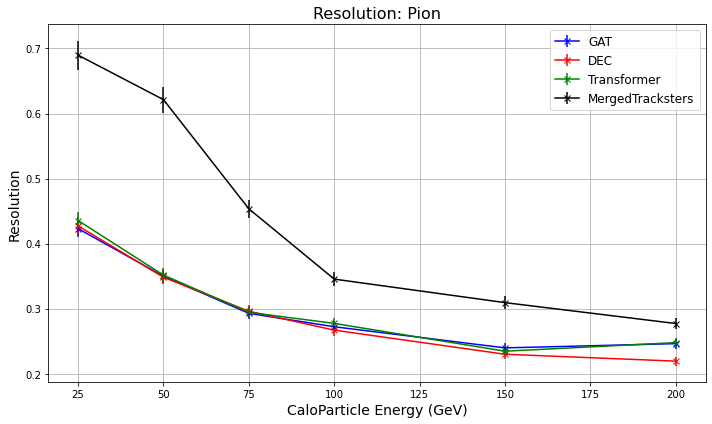

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define allowed energies for CaloParticles and the number of bins.
allowed_energies = np.array([25, 50, 75, 100, 150, 200])
n_bins = len(allowed_energies)

def process_cp_dataframe(df):
    """
    Convert columns to numeric and keep only events with exactly one calo particle id 
    (selecting the row with highest shared_energy if needed).
    """
    df = df.copy()
    for col in ['cp_id', 'cp_energy', 'energy_ratio', 'shared_energy']:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # For each (event_index, cp_id), keep the row with the highest shared_energy.
    df_cp = df.loc[df.groupby(['event_index', 'cp_id'])['shared_energy'].idxmax()].reset_index(drop=True)
    
    # Only keep events that have exactly one unique cp_id.
    valid_events = df_cp.groupby('event_index')['cp_id'].nunique()
    valid_events = valid_events[valid_events == 1].index
    df_cp = df_cp[df_cp['event_index'].isin(valid_events)]
    
    return df_cp

# Create a mapping to assign each cp_energy value to a bin.
energy_to_bin = {energy: idx for idx, energy in enumerate(allowed_energies)}

def compute_scaled_sigma_effective(df, num_bins):
    """
    For each energy bin, scale the energy_ratio data so that the mean is 1, 
    then compute the sigma effective as the width of the narrowest window covering 68.3% of the data.
    """
    effective_mean_scaled, sigma_eff_scaled, counts = [], [], []
    for b in range(num_bins):
        bin_data = df.loc[df['energy_bin'] == b, 'energy_ratio'].dropna()
        counts.append(len(bin_data))
        if len(bin_data) > 0:
            mean_arith = np.mean(bin_data)
            scaled_data = bin_data / mean_arith
            sorted_data = np.sort(scaled_data)
            n_points = len(sorted_data)
            window_size = max(1, int(0.683 * n_points))
            min_width = np.inf
            best_range = (None, None)
            for i in range(n_points - window_size):
                width = sorted_data[i + window_size] - sorted_data[i]
                if width < min_width:
                    min_width = width
                    best_range = (sorted_data[i], sorted_data[i + window_size])
            mu_eff = (best_range[0] + best_range[1]) / 2 
            sigma_eff_val = (best_range[1] - best_range[0]) / np.sqrt(2)
            effective_mean_scaled.append(mu_eff)
            sigma_eff_scaled.append(sigma_eff_val)
        else:
            effective_mean_scaled.append(np.nan)
            sigma_eff_scaled.append(np.nan)
    return np.array(effective_mean_scaled), np.array(sigma_eff_scaled), np.array(counts)

# Load the CSV dataframes (assuming these variables are defined/imported elsewhere)
# Process each dataframe
df_GAT_proc   = process_cp_dataframe(df_GAT)
df_DE_proc    = process_cp_dataframe(df_DE)
df_Trans_proc = process_cp_dataframe(df_Trans)
df_Track_proc = process_cp_dataframe(df_Track)  # This will be processed but not plotted.
df_MT_proc    = process_cp_dataframe(df_MT)

# Map each cp_energy to a bin based on the allowed energies.
df_GAT_proc['energy_bin']   = df_GAT_proc['cp_energy'].map(energy_to_bin)
df_DE_proc['energy_bin']    = df_DE_proc['cp_energy'].map(energy_to_bin)
df_Trans_proc['energy_bin'] = df_Trans_proc['cp_energy'].map(energy_to_bin)
df_Track_proc['energy_bin'] = df_Track_proc['cp_energy'].map(energy_to_bin)
df_MT_proc['energy_bin']    = df_MT_proc['cp_energy'].map(energy_to_bin)

# Compute the resolution (sigma effective) and counts for each algorithm.
_, sigma_GAT,   counts_GAT   = compute_scaled_sigma_effective(df_GAT_proc, n_bins)
_, sigma_DE,    counts_DE    = compute_scaled_sigma_effective(df_DE_proc, n_bins)
_, sigma_Trans, counts_Trans = compute_scaled_sigma_effective(df_Trans_proc, n_bins)
_, sigma_Track, counts_Track = compute_scaled_sigma_effective(df_Track_proc, n_bins)  # Not plotted.
_, sigma_MT,    counts_MT    = compute_scaled_sigma_effective(df_MT_proc, n_bins)

# Calculate approximate error bars: error = sigma / sqrt(count)
# Adding a tiny epsilon in sqrt to avoid division by zero if needed.
epsilon = 1e-8
sigma_err_GAT   = sigma_GAT   / np.sqrt(counts_GAT + epsilon)
sigma_err_DE    = sigma_DE    / np.sqrt(counts_DE  + epsilon)
sigma_err_Trans = sigma_Trans / np.sqrt(counts_Trans + epsilon)
sigma_err_MT    = sigma_MT    / np.sqrt(counts_MT  + epsilon)

# Plot the resolution curves for four methods (excluding Tracksters) with error bars.
plt.figure(figsize=(10,6))

plt.errorbar(allowed_energies, sigma_GAT,   yerr=sigma_err_GAT,   fmt='x-', color='blue',   label='GAT')
plt.errorbar(allowed_energies, sigma_DE,    yerr=sigma_err_DE,    fmt='x-', color='red',    label='DEC')
plt.errorbar(allowed_energies, sigma_Trans, yerr=sigma_err_Trans, fmt='x-', color='green',  label='Transformer')
plt.errorbar(allowed_energies, sigma_MT,    yerr=sigma_err_MT,    fmt='x-', color='black',  label='MergedTracksters')

plt.xlabel('CaloParticle Energy (GeV)', fontsize=14)
plt.ylabel('Resolution', fontsize=14)
plt.title('Resolution: Pion', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.savefig("PionRes.pdf")
plt.show()


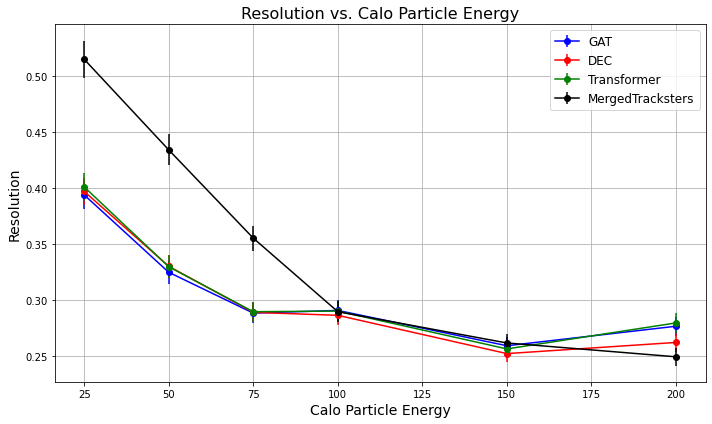

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define allowed energies for CaloParticles
allowed_energies = np.array([25, 50, 75, 100, 150, 200])
n_bins = len(allowed_energies)

def process_cp_dataframe(df):
    """
    Convert columns to numeric and keep only events with exactly one calo particle id
    (selecting the row with highest shared_energy if needed).
    """
    df = df.copy()
    for col in ['cp_id', 'cp_energy', 'energy_ratio', 'shared_energy']:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        
    # For each (event_index, cp_id), keep the row with the highest shared_energy.
    df_cp = df.loc[df.groupby(['event_index', 'cp_id'])['shared_energy'].idxmax()].reset_index(drop=True)
    
    # Only keep events that have exactly one unique cp_id.
    valid_events = df_cp.groupby('event_index')['cp_id'].nunique()
    valid_events = valid_events[valid_events == 1].index
    df_cp = df_cp[df_cp['event_index'].isin(valid_events)]
    
    return df_cp

# Load the CSV dataframes
df_GAT   = pd.read_csv("csvRes/df_GAT_pi_res.csv")
df_DE    = pd.read_csv("csvRes/df_DEC_pi_res.csv")
df_Trans = pd.read_csv("csvRes/df_Trans_pi_res.csv")
df_MT    = pd.read_csv("csvRes/df_MT_pi_res.csv")

# Process each dataframe
df_GAT_proc   = process_cp_dataframe(df_GAT)
df_DE_proc    = process_cp_dataframe(df_DE)
df_Trans_proc = process_cp_dataframe(df_Trans)
df_MT_proc    = process_cp_dataframe(df_MT)

# Create a mapping to assign each cp_energy to a bin
energy_to_bin = {energy: idx for idx, energy in enumerate(allowed_energies)}

df_GAT_proc['energy_bin']   = df_GAT_proc['cp_energy'].map(energy_to_bin)
df_DE_proc['energy_bin']    = df_DE_proc['cp_energy'].map(energy_to_bin)
df_Trans_proc['energy_bin'] = df_Trans_proc['cp_energy'].map(energy_to_bin)
df_MT_proc['energy_bin']    = df_MT_proc['cp_energy'].map(energy_to_bin)

def compute_scaled_sigma_effective(df, num_bins):
    """
    For each energy bin, scale the energy_ratio data so that the mean is 1,
    then compute the resolution as the standard deviation of the scaled data.
    """
    sigma_eff_scaled, counts = [], []
    for b in range(num_bins):
        bin_data = df.loc[df['energy_bin'] == b, 'energy_ratio'].dropna()
        counts.append(len(bin_data))
        if len(bin_data) > 0:
            mean_arith = np.mean(bin_data)
            scaled_data = bin_data / mean_arith
            sigma_eff_val = np.std(scaled_data)
            sigma_eff_scaled.append(sigma_eff_val)
        else:
            sigma_eff_scaled.append(np.nan)
    return np.array(sigma_eff_scaled), np.array(counts)

# Compute the resolution and counts per bin for each model.
scaled_sigma_eff_GAT,   counts_GAT   = compute_scaled_sigma_effective(df_GAT_proc, n_bins)
scaled_sigma_eff_DE,    counts_DE    = compute_scaled_sigma_effective(df_DE_proc, n_bins)
scaled_sigma_eff_Trans, counts_Trans = compute_scaled_sigma_effective(df_Trans_proc, n_bins)
scaled_sigma_eff_MT,    counts_MT    = compute_scaled_sigma_effective(df_MT_proc, n_bins)

# Estimate error bars: error = sigma / sqrt(N)
epsilon = 1e-8  # to prevent division by zero
sigma_err_GAT   = scaled_sigma_eff_GAT   / np.sqrt(counts_GAT   + epsilon)
sigma_err_DE    = scaled_sigma_eff_DE    / np.sqrt(counts_DE    + epsilon)
sigma_err_Trans = scaled_sigma_eff_Trans / np.sqrt(counts_Trans + epsilon)
sigma_err_MT    = scaled_sigma_eff_MT    / np.sqrt(counts_MT    + epsilon)

# Plot the resolution curves for all four models with error bars.
plt.figure(figsize=(10, 6))

plt.errorbar(allowed_energies, scaled_sigma_eff_GAT, yerr=sigma_err_GAT, fmt='o-', color='blue',   label='GAT')
plt.errorbar(allowed_energies, scaled_sigma_eff_DE,  yerr=sigma_err_DE,  fmt='o-', color='red',    label='DEC')
plt.errorbar(allowed_energies, scaled_sigma_eff_Trans, yerr=sigma_err_Trans, fmt='o-', color='green',  label='Transformer')
plt.errorbar(allowed_energies, scaled_sigma_eff_MT,    yerr=sigma_err_MT,    fmt='o-', color='black',  label='MergedTracksters')

plt.xlabel('Calo Particle Energy', fontsize=14)
plt.ylabel('Resolution', fontsize=14)
plt.title('Resolution vs. Calo Particle Energy', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()
